This script filters households based on certain criteria to ensure only households with high-quality responses are kept.

Data sources:
- Selected survey questions: 'selected_survey_questions.csv'
- Responses to selected survey questions: 'responses_to_selected_survey_questions.csv'

Both files should be in the same directory as this script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_questions = pd.read_csv('selected_survey_questions.csv')
df_survey_raw = pd.read_csv('responses_to_selected_survey_questions.csv')

# Filter only households in group D, the treatment group
df_survey_d = df_survey_raw[df_survey_raw['Household_id'].str.startswith('D')]
print(f"Number of households in group D who responded to the survey: {len(df_survey_d)}")

Number of households in group D who responded to the survey: 942


# Remove households based on certain criteria

In [2]:
# Remove specified households from script 1 (insufficient consumption data)
households_to_remove = ['D0041', 'D0093', 'D0125', 'D0134', 'D0212', 'D0241', 'D0332', 'D0381', 'D0417', 'D0477', 'D0586', 'D0643', 'D0668', 'D0723', 'D0734', 'D0862', 'D0873', 'D0967']
df_survey_d = df_survey_d[~df_survey_d['Household_id'].isin(households_to_remove)]
print(f"Number of households removed based on predefined list: {len(households_to_remove)}")
print(f"Number of households remaining after removal: {len(df_survey_d)}")

# Remove households without a single response to Q01-Q17 (attitudes survey)
attitudes_questions = [f'Q{i:02d}' for i in range(1, 18)]
df_survey_d['attitudes_response_count'] = df_survey_d[attitudes_questions].notna().sum(axis=1)
df_survey_attitudes = df_survey_d[df_survey_d['attitudes_response_count'] > 0]
removed_attitudes = len(df_survey_d) - len(df_survey_attitudes)
print(f"2. Number of households removed due to lack of response to attitudes survey: {removed_attitudes}")

# Remove households without a single response to Q18-Q135 (appliances survey)
appliances_questions = [f'Q{i}' for i in range(18, 136)]
df_survey_attitudes['appliances_response_count'] = df_survey_attitudes[appliances_questions].notna().sum(axis=1)
df_survey_filtered = df_survey_attitudes[df_survey_attitudes['appliances_response_count'] > 0]
removed_appliances = len(df_survey_attitudes) - len(df_survey_filtered)
print(f"3. Number of households removed due to lack of response to appliances survey: {removed_appliances}")

# Print how many were removed in each step
print(f"\nTotal households removed: {removed_attitudes + removed_appliances}")
print(f"Final number of households: {len(df_survey_filtered)}")

# Create a dictionary mapping question IDs to full questions
question_dict = dict(zip(df_questions['Question_id'], df_questions['Question']))

Number of households removed based on predefined list: 18
Number of households remaining after removal: 927
2. Number of households removed due to lack of response to attitudes survey: 246
3. Number of households removed due to lack of response to appliances survey: 58

Total households removed: 304
Final number of households: 623


C:\Users\RaiN\AppData\Local\Temp\ipykernel_36664\4010653781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survey_attitudes['appliances_response_count'] = df_survey_attitudes[appliances_questions].notna().sum(axis=1)


# Filter households based on response rates

In [3]:
# Find the most frequently un-answered questions
all_response_counts = df_survey_filtered.isna().sum().sort_values(ascending=False)

print("\nTop 10 most frequently un-answered questions:")
for q_id, count in all_response_counts.head(10).items():
    full_question = question_dict.get(q_id, "Question text not found")
    print(f"{q_id} - {full_question} | {count}")


Top 10 most frequently un-answered questions:
Q34 - Household Member 8 Age | 623
Q26 - Household Member 8 Gender | 623
Q25 - Household Member 7 Gender | 623
Q33 - Household Member 7 Age | 623
Q39 - Accomodation: Mobile | 621
Q32 - Household Member 6 Age | 620
Q121 - TV Type 6 | 620
Q127 - TV Size 6 | 620
Q24 - Household Member 6 Gender | 619
Q126 - TV Size 5 | 615


# From the analysis, it is clear that some questions (such as household member 8's age) should be removed form the top un-answered questions list.

In [4]:
# Define the list of questions to exclude
exclude_ranges = [
    (1, 11),    # Appliance-specific questions: Not all households have every appliance
    (12, 17),   # Timer switch usage: Also appliance-specific
    (19, 26),   # Household member gender: Not applicable for all household sizes
    (27, 34),   # Household member age: Not applicable for all household sizes
    (37, 39),   # Accommodation type: Mutually exclusive questions
    (116, 127)  # Specific appliance details (TV): Not all households have these appliances
]
exclude_questions = [f'Q{i:02d}' for r in exclude_ranges for i in range(r[0], r[1]+1)]

# Calculate adjusted response rate
included_columns = [col for col in df_survey_filtered.columns if col not in exclude_questions and col != 'Household_id']
df_survey_filtered.loc[:, 'adjusted_response_rate'] = df_survey_filtered[included_columns].notna().sum(axis=1) / len(included_columns)

print("Adjusted response rate calculated. This rate excludes questions that may not be applicable to all households,")
print("providing a more accurate representation of survey completion.")

Adjusted response rate calculated. This rate excludes questions that may not be applicable to all households,
providing a more accurate representation of survey completion.


C:\Users\RaiN\AppData\Local\Temp\ipykernel_36664\2949584156.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survey_filtered.loc[:, 'adjusted_response_rate'] = df_survey_filtered[included_columns].notna().sum(axis=1) / len(included_columns)


In [5]:
# Eliminate households with >20% non-response rate
df_survey_filtered_80 = df_survey_filtered[df_survey_filtered['adjusted_response_rate'] >= 0.8].copy()

print(f"Number of households after removing those with >20% non-response rate: {len(df_survey_filtered_80)}")

# Remove households with inconsistent demographic information
def demo_missing_or_inconsistent(row):
    household_size_missing = pd.isna(row['Q18'])
    all_gender_missing = all(pd.isna(row[f'Q{i}']) for i in range(19, 27))
    all_age_missing = all(pd.isna(row[f'Q{i}']) for i in range(27, 35))
    all_missing = household_size_missing and all_gender_missing and all_age_missing
    size = row['Q18'] if pd.notna(row['Q18']) else 0
    gender_count = sum(pd.notna(row[f'Q{i}']) for i in range(19, 27))
    age_count = sum(pd.notna(row[f'Q{i}']) for i in range(27, 35))
    all_disagree = (size != gender_count) and (size != age_count) and (gender_count != age_count)
    return all_missing or all_disagree

df_survey_filtered_80['demo_missing_or_inconsistent'] = df_survey_filtered_80.apply(demo_missing_or_inconsistent, axis=1)
df_survey_final = df_survey_filtered_80[~df_survey_filtered_80['demo_missing_or_inconsistent']].copy()

print(f"Total number of households remaining in the final dataset: {len(df_survey_final)}")

Number of households after removing those with >20% non-response rate: 622
Total number of households remaining in the final dataset: 608


### Let's take a look at what the adjusted response rate (after excluding the questions identified above) looks like

In [6]:
# Drop temporary columns
df_survey_final_export = df_survey_final.drop(columns=['adjusted_response_rate', 'attitudes_response_count', 'appliances_response_count', 'demo_missing_or_inconsistent'])

# Export the final cleaned dataset
df_survey_final_export.to_csv('2) responses_to_selected_survey_questions_filtered.csv', index=False)
print("\nFinal cleaned survey dataset has been exported to ''2) responses_to_selected_survey_questions_filtered.csv'")


Final cleaned survey dataset has been exported to ''2) responses_to_selected_survey_questions_filtered.csv'


In [7]:
# Print some information for verification purposes
print(f"Number of households in final dataset: {len(df_survey_final_export)}")
print(f"Columns in final dataset: {df_survey_final_export.columns.tolist()}")

Number of households in final dataset: 608
Columns in final dataset: ['Household_id', 'Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70', 'Q71', 'Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79', 'Q80', 'Q81', 'Q82', 'Q83', 'Q84', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q90', 'Q91', 'Q92', 'Q93', 'Q94', 'Q95', 'Q96', 'Q97', 'Q98', 'Q99', 'Q100', 'Q101', 'Q102', 'Q103', 'Q104', 'Q105', 'Q106', 'Q107', 'Q108', 'Q109', 'Q110', 'Q111', 'Q112', 'Q113', 'Q114', 'Q115', 'Q116', 'Q117', 'Q118', 'Q119', 'Q120', 'Q121', 'Q122', 'Q123', 'Q124', 'Q125', 'Q126', 'Q127

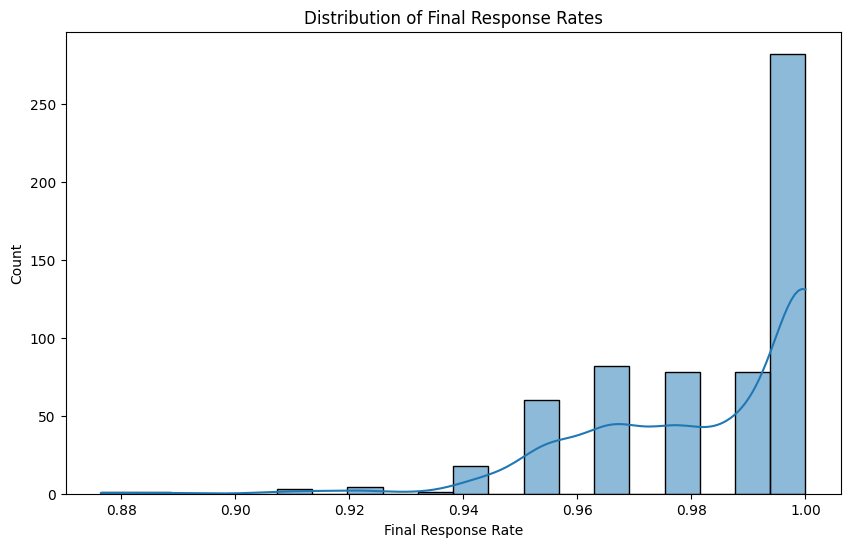

In [8]:
# Visualize final response rates
plt.figure(figsize=(10, 6))
sns.histplot(df_survey_final['adjusted_response_rate'], bins=20, kde=True)
plt.title('Distribution of Final Response Rates')
plt.xlabel('Final Response Rate')
plt.ylabel('Count')
plt.show()